## Libraries

In [4]:
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk, re
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn import tree as tre



## Defining the Functions

In [5]:
# Text preprocessing: lowercase, removing numbers, removing punctuation except '.'
def clean_txt(txt):
    result = txt.lower()
    result = ''.join([r for r in result if not r.isdigit()])
    #result = result.translate(str.maketrans("","", '!"#$%&\'()*+,-/:;<=>?@[\\]^_`{|}~')) 
    return(result)

## Anaphora Finder 

In [6]:
# Search in the corpus for anaphora cases, i.e. repetition of n-tokens at the beginning of adjacent sentences
def find_anaphora (txt, n):
    sent_tokenized = sent_tokenize(txt)
    dataset = []
    tmp = []
    repetition = False
    copied = False
    for i in range(len(sent_tokenized) - 1):
        prev_sent = clean_txt(sent_tokenized[i])
        next_sent = clean_txt(sent_tokenized[i + 1])
        prev_phrase = get_sentence_start(prev_sent, n)
        next_phrase = get_sentence_start(next_sent, n)
        if prev_phrase == next_phrase and prev_phrase != '' and next_phrase != '' :
            if repetition == False:
                tmp.append(prev_sent)
                tmp.append(next_sent)
                repetition = True
            else:
                tmp.append(next_sent)
        else:
            if len(tmp) >= 3:
                tmp_str = ''
                strong_punc = False
                for w in tmp:
                    tmp_str += w
                words = word_tokenize(tmp_str)
                if words[-1] != '.':
                    strong_punc = True
                dataset.append(tuple((tmp_str, len(tmp), round(len(words)/len(tmp)), strong_punc)))
                copied = True
            tmp = []
            repetition = False
    if not copied and len(tmp) >= 3:
        tmp_str = ''
        strong_punc = False
        for w in tmp:
            tmp_str += w
        words = word_tokenize(tmp_str)
        if words[-1] != '.':
            strong_punc = True
        dataset.append(tuple((tmp_str, len(tmp), round(len(words)/len(tmp)), strong_punc)))
    return dataset

# Returns n-first tokens of a sentence, used inside findAnaphora function for comparing the sentence start
def get_sentence_start(sentence, n):
    tmp = []
    tokens = word_tokenize(sentence)
    if len(tokens) >= n:
        for i in range(n):
            if i == n-1:
                tmp.append(tokens[i])
            else:
                tmp.append(tokens[i] + ' ')
    if len(tmp) >= 1:
        str_txt = ''.join(tmp)
    else:
        str_txt = ''
    return str_txt

## Epistrophe Finder

In [7]:
# Search in the corpus for epistrophe cases, i.e. repetition of n-tokens at the end of adjacent sentences
def find_Epistrophe (txt, n):
    sent_tokenized = re.split("[.,?!;:]", txt)
    dataset = []
    tmp = []
    repetition = False
    copied = False
    identical = False
    for i in range(len(sent_tokenized) - 1):
        diff = 0.0        
        prev_sent = clean_txt(sent_tokenized[i]).strip()
        next_sent = clean_txt(sent_tokenized[i + 1]).strip()
        prev_phrase = get_sentence_end(prev_sent, n)
        next_phrase = get_sentence_end(next_sent, n)
        if prev_phrase == next_phrase and prev_phrase != '' and next_phrase != '' :
            if repetition == False:
                tmp.append(prev_sent + '.')
                tmp.append(next_sent + '.')                
                repetition = True
            else:
                tmp.append(next_sent + '.')
        else:
            if len(tmp) >= 3:
                lengths = []
                tmp_str = ''
                dif = 0 
                for r in range(len(tmp) - 1):
                    if tmp[r] == tmp[r + 1]:
                        identical = True                    
                for w in tmp:
                    words = word_tokenize(w)
                    lengths.append(len(words))
                    tmp_str += w   
                for l in range(len(lengths) - 1):
                    dif += abs(lengths[l] - lengths[l+1])
                dataset.append(tuple((tmp_str, dif, len(tmp), identical)))
                copied = True
            tmp = []
            repetition = False
            identical = False
    if not copied and len(tmp) >= 3:
        lengths = []
        tmp_str = ''
        dif = 0
        for r in range(len(tmp) - 1):
                    if tmp[r] == tmp[r + 1]:
                        identical = True
        for w in tmp:
            words = word_tokenize(w)
            lengths.append(len(words))
            tmp_str += w
        for l in range(len(lengths) - 1):
            dif += abs(lengths[l] - lengths[l+1])
        dataset.append(tuple((tmp_str, dif, len(tmp), identical)))
    return dataset


# Returns n-last tokens of a sentence, used inside findEpistrophe function for comparing the sentence end
def get_sentence_end(sentence, n):
    #sentence = clean_txt(sentence)
    tmp = []
    clean_s = re.sub("\.", "", sentence)
    tokens = word_tokenize(clean_s)
    if len(tokens) >= n:
        for j in range(n, 0, -1):
            if j == 1:
                tmp.append(tokens[-j])
            else:
                tmp.append(tokens[-j] + ' ')
    if len(tmp) >= 1:
        str_txt = ''.join(tmp)
    else:
        str_txt = ''
    return str_txt

## Epanalepsis Finder

In [8]:
# Search in the corpus for epanalepsis cases, i.e. repetition of n-tokens at the beginning and at the end of the same sentence
def find_epana (txt, n):
    sent_tokenized = sent_tokenize(txt)
    dataset = []
    tmp = []
    copied = False
    for i in range(len(sent_tokenized) - 1):
        sent = clean_txt(sent_tokenized[i])
        start_phrase = get_sentence_start(sent, n)
        end_phrase = get_sentence_end(sent, n)
        if start_phrase == end_phrase and start_phrase != '' and end_phrase != '' :
                tmp_str = ''
                tmp.append(sent)
                for w in tmp:
                    tmp_str += w
                words = word_tokenize(tmp_str)
                if len(words) >= 5:
                    dataset.append(tuple((tmp_str, len(words))))
                    copied = True
                    tmp = []
                else:
                    tmp= []
    if not copied:
        tmp_str = ''
        tmp.append(sent)
        for w in tmp:
            tmp_str += w
        words = word_tokenize(tmp_str)
        if len(words) >= 5:
            dataset.append(tuple((tmp_str, len(words))))
            tmp = []
        else:
            tmp= []

    return dataset

## Data Acquisition

In [9]:
f = pd.read_csv("corpus.csv")
keep_col = ['transcripts']
new_f = f[keep_col]
data = ""
for i in new_f['transcripts']:
    data = data + i
#new_f.to_csv("newFile.csv", index=False) #inorder to make new file with only transcripts

In [10]:
len(word_tokenize(data)) #Corpus contains around 4.2 million words

4210621

## Search Anaphora

In [11]:
ana_result = find_anaphora(data, 3)

In [12]:
print(ana_result)

[('is there one among our citizens who would not prefer perpetual peace with texas to occasional wars, which so often occur between bordering independent nations?is there one who would not prefer free intercourse with her to high duties on all our products and manufactures which enter her ports or cross her frontiers?is there one who would not prefer an unrestricted communication with her citizens to the frontier obstructions which must occur if she remains out of the union?', 3, 28, True), ('if it be, the question is decided.if it be not expressed, the next inquiry must be whether it is properly an incident to an expressed power and necessary to its execution.if it be, it may be exercised by congress.if it be not, congress can not exercise it.', 4, 13, False), ('it will be found by applying the restriction thus understood to the bill under consideration that it contains appropriations for more than twenty objects of internal improvement, called in the bill harbors, at places which hav

In [13]:
len(ana_result)

372

## Search Epistrophe

In [11]:
epi_result = find_Epistrophe(data, 2)

In [12]:
print(epi_result)

[('the conventions of  -  -.and of  -  -.will expire by their own limitation on  -  -.', 6, 3, False), ('the next session of the chambers commenced on  -  -.and continued until  -  -.a new bill was introduced on  -  -.', 8, 3, False), ('it is created by law.is amendable by law.and is repealable by law.', 2, 3, False), ('and commerce with the republic of new granada.among the conditions of which was a stipulation on the part of new granada guaranteeing to the united states the right of way or transit across that part of the isthmus which lies in the territory of new granada.in consideration of which the united states guaranteed in respect of the same territory the rights of sovereignty and property of new granada.', 47, 3, False), ('between her britannic majesty and the republic of honduras.constituted and declared a free territory under the sovereignty of the said republic of honduras.” stipulated that “the two contracting parties do hereby mutually engage to recognize and respect in a

In [13]:
len(epi_result)

133

## Search Epanalepsis

In [14]:
epa_result = find_epana(data, 2)

In [15]:
epa_result 

[('the revenue cutter service has been organized and placed on a good footing, and aided by an increase of inspectors at exposed points, and regulations adopted under the act of [  -  ], for the inspection and appraisement of merchandise, has produced much improvement in the execution of the laws and more security against the commission of frauds upon the revenue.',
  66),
 ('each party claiming a right to the territory, and hence to the exclusive jurisdiction over it, it is manifest that to prevent the destruction of the timber by trespassers, acting against the authority of both, and at the same time avoid forcible collision between the contiguous governments during the pendency of negotiations concerning the title, resort must be had to the mutual exercise of jurisdiction in such extreme cases or to an amicable and temporary arrangement as to the limits within which it should be exercised by each party.',
  95),
 ('those of , exclusive of disbursements for public debt and trust clai

In [16]:
len(epa_result) 

57

## Construct DataFrame 

In [15]:
#Dataframe for Epiphora
#Choosen Features: Number of successive sentences, Average Length of Sentences, if a sentence has strong punctuation, if sentences are identical

df_a = pd.DataFrame(ana_result, columns=["Text", "No of Successive Sent", "AvgLength of sent", "StrongPunctuation"]) 
labels_a = [0,0,0,0,0,0,1,1,0,1,0,1,1,1,1,1,0,0,1,0,
            0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,
            1,1,1,1,0,0,1,0,1,1,1,1,0,0,0,1,1,0,1,1,
            0,1,1,1,0,1,1,0,0,1,1,0,0,1,0,0,1,1,0,0,
            0,0,1,0,0,1,1,1,1,1,1,0,0,1,0,1,1,0,1,0,
            1,1,1,1,1,0,0,0,1,0,0,1,1,0,0,1,1,0,1,1,
            1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,0,0,0,0,0,
            1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,
            0,1,1,1,1,1,1,1,0,1,0,1,1,1,0,1,1,1,1,1,
            0,1,0,1,0,1,0,1,0,1,1,1,1,0,1,1,0,1,0,1,
            0,1,1,0,0,1,1,1,1,0,1,1,0,1,1,0,1,0,1,0,
            0,1,1,0,0,0,0,0,0,1,1,0,0,1,1,0,1,1,1,1,
            0,0,1,0,1,1,0,1,0,1,1,0,1,0,1,1,1,1,0,1,
            1,1,0,0,0,1,0,1,1,1,1,0,0,0,1,1,0,1,1,1,
            1,1,1,1,1,1,1,0,0,0,1,1,0,1,1,0,0,1,1,0,
            0,1,0,0,1,0,1,0,0,1,1,1,0,0,1,0,1,0,1,1,
            0,1,0,1,1,1,1,1,0,1,1,1,0,0,0,1,0,0,0,1,
            1,1,1,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,
            1,0,1,0,1,0,1,1,0,1,0,1]

df_a.insert(4, "isAnaphora", labels_a, True)
df_a

,Text,No of Successive Sent,AvgLength of sent,StrongPunctuation,isAnaphora
0,is there one among our citizens who would not ...,3,28,True,0
1,"if it be, the question is decided.if it be not...",4,13,False,0
2,it will be found by applying the restriction t...,4,52,False,0
3,it was the interest of the bank that the reven...,3,44,False,0
4,is it the fact that in all the unsettled regio...,3,51,True,0
...,...,...,...,...,...
367,this is the time to re ignite the american ima...,3,18,False,1
368,you can't take big loads because you have peop...,3,19,False,0
369,we could do all of these different things so e...,3,8,False,1
370,it's going up in new mexico.it's going up in a...,3,8,False,0


In [16]:
#Dataframe for Epiphora
#Choosen Features: Sentence length difference, Average Length of Sentences, if a sentence has strong punctuation, if sentences are identical

df_e = pd.DataFrame(epi_result, columns=["Text", "Sent Length Difference", "No of Successive Sent", "isIdentical"])
labels_e = [0,0,1,0,0,0,1,0,0,1,
            1,0,0,0,0,0,1,0,1,0,
            1,0,1,1,1,1,0,0,0,0,
            0,0,1,1,1,1,0,0,0,0,
            0,0,0,1,1,1,0,1,0,1,
            1,1,1,0,1,1,1,1,1,1,
            1,0,1,1,1,1,1,1,1,0,
            0,1,0,1,0,0,1,0,1,0,
            1,1,1,1,0,0,1,1,1,1,
            0,0,0,1,1,1,1,1,1,1,
            1,1,1,1,1,0,0,1,1,0,
            0,0,0,0,1,1,1,1,1,0,
            1,1,1,0,0,0,1,0,0,1,
            0,0,0]
df_e.insert(4, "isEpiphora", labels_e, True)
df_e

,Text,Sent Length Difference,No of Successive Sent,isIdentical,isEpiphora
0,the conventions of - -.and of - -.will exp...,6,3,False,0
1,the next session of the chambers commenced on ...,8,3,False,0
2,it is created by law.is amendable by law.and i...,2,3,False,1
3,and commerce with the republic of new granada....,47,3,False,0
4,between her britannic majesty and the republic...,28,3,False,0
...,...,...,...,...,...
128,“don't do it.don't do it.don't do it.,1,3,True,0
129,i want those companies—and they're starting—i ...,8,3,False,1
130,“how is your drug problem.” “we don't have muc...,7,3,False,0
131,thank you.thank you.thank you.thank you.thank ...,0,5,True,0


In [17]:
#DataFrame for Epanalepsis
#Choosen Features: Sentence Length

df_epa = pd.DataFrame(epa_result, columns=["Text", "len"]) 
labels_epa = [0,0,0,0,1,1,0,0,0,0,
             0,0,0,0,1,0,0,0,0,1,
             1,0,0,0,0,0,0,1,0,0,
             0,0,0,0,0,0,1,1,0,0,
             0,0,0,0,0,0,0,0,0,0,
             0,0,0,0,0,0,0,]
df_epa.insert(2, "isEpanalepsis", labels_epa, True)
df_epa

,Text,len,isEpanalepsis
0,the revenue cutter service has been organized ...,66,0
1,"each party claiming a right to the territory, ...",95,0
2,"those of , exclusive of disbursements for publ...",42,0
3,"the president of that republic, in submitting ...",98,0
4,"the occasion is piled high with difficulty, an...",16,1
5,"the whole can not exist withoutthe parts, nor ...",15,1
6,the government is subordinate to the people; b...,49,0
7,the correspondence on this subject with the le...,34,0
8,the contract of the maritime canal company of ...,38,0
9,"last year, , it had risen to seventy billion d...",27,0


## Machine Learning

Anaphora

In [43]:
# Train and test data for Anaphora

x_a = df_a[["No of Successive Sent", "AvgLength of sent", "StrongPunctuation"]]
y_a = df_a["isAnaphora"]

x_train_a, x_test_a, y_train_a, y_test_a = train_test_split(x_a, y_a, test_size=0.2)

In [44]:
clf = DecisionTreeClassifier(max_depth=3)
clf = clf.fit(x_train_a,y_train_a)
y_pred = clf.predict(x_test_a)
print("Accuracy:",metrics.accuracy_score(y_test_a, y_pred))
print("F1 Score:",metrics.f1_score(y_test_a, y_pred))

Accuracy: 0.7066666666666667
F1 Score: 0.7924528301886792


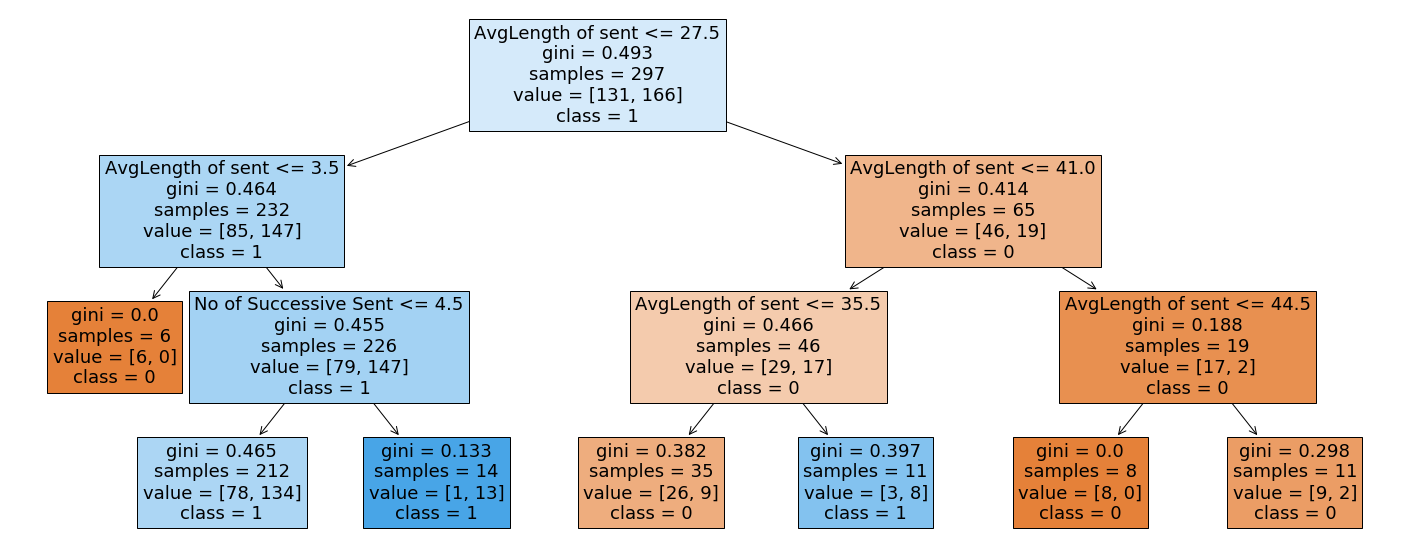

In [84]:
fig = plt.figure(figsize=(25,10))
_ = tre.plot_tree(clf, 
                  fontsize=18,
                   feature_names=["No of Successive Sent", "AvgLength of sent", "StrongPunctuation"],  
                   class_names=['0','1'],
                   filled=True)
plt.savefig('anaphora_dt.png')

Epistrophe

In [45]:
x_ep = df_e[["Sent Length Difference", "No of Successive Sent","isIdentical"]]
y_ep = df_e["isEpiphora"]

x_train_ep, x_test_ep, y_train_ep, y_test_ep = train_test_split(x_ep, y_ep, test_size=0.2) 

In [46]:
clf = DecisionTreeClassifier(max_depth=3)
clf = clf.fit(x_train_ep,y_train_ep)
y_pred = clf.predict(x_test_ep)
print("Accuracy:",metrics.accuracy_score(y_test_ep, y_pred))
print("F1 Score:",metrics.f1_score(y_test_ep, y_pred))

Accuracy: 0.7407407407407407
F1 Score: 0.8


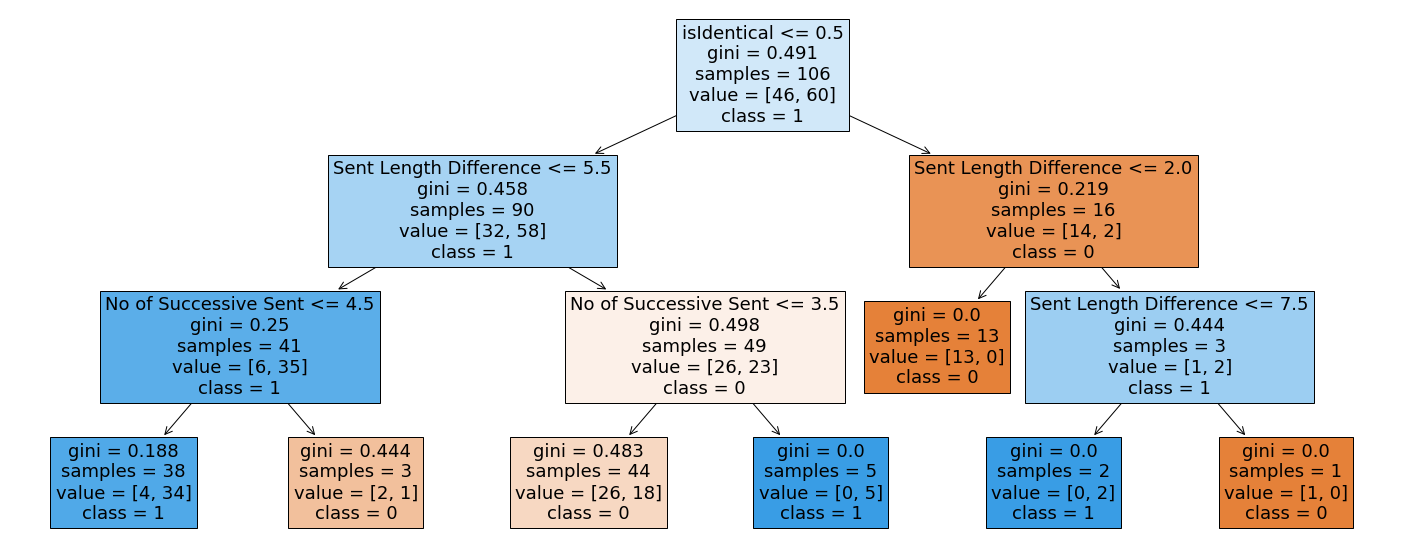

In [91]:
fig = plt.figure(figsize=(25,10))

_ = tre.plot_tree(clf, 
                    fontsize=18,
                   feature_names=["Sent Length Difference", "No of Successive Sent","isIdentical"],  
                   class_names=['0','1'],
                   filled=True)
plt.savefig('epiphora_dt.png')

Epanalepsis

In [58]:
x_epa = df_epa[["len"]]
y_epa = df_epa["isEpanalepsis"]

x_train_epa, x_test_epa, y_train_epa, y_test_epa = train_test_split(x_epa, y_epa, test_size=0.2) 

In [61]:
print(y_pred)

[1 0 0 0 0 0 0 0 0 0 0 0]


In [60]:
clf = DecisionTreeClassifier(max_depth=3)
clf = clf.fit(x_train_epa,y_train_epa)
y_pred = clf.predict(x_test_epa)
print("Accuracy:",metrics.accuracy_score(y_test_epa, y_pred))
print("F1 Score:",metrics.f1_score(y_test_epa, y_pred))

Accuracy: 0.8333333333333334
F1 Score: 0.5


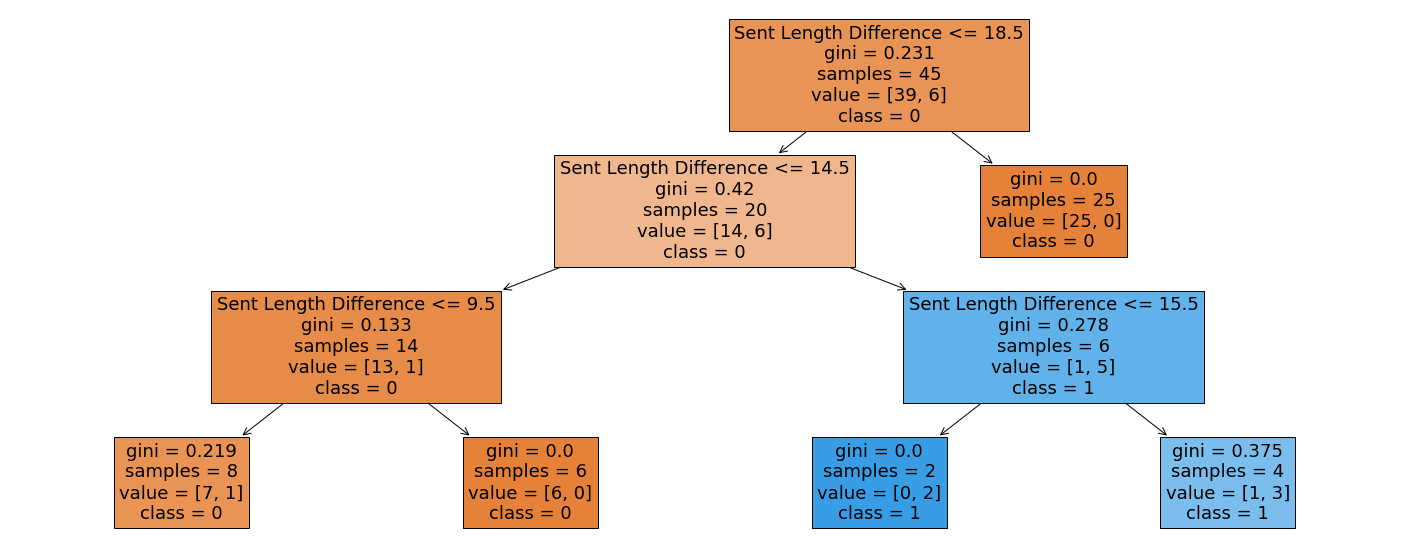

In [23]:
fig = plt.figure(figsize=(25,10))

_ = tre.plot_tree(clf, 
                    fontsize=18,
                   feature_names=["len"],  
                   class_names=['0','1'],
                   filled=True)
plt.savefig('epanalepsis_dt.png')